## Notebook to make joint plots of the normalized frontogenesis function. 
See ```/analysis_notebooks/``` for definition of terms and equations 

In [1]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime
from timeit import default_timer as timer
from xhistogram.xarray import histogram

import glob
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib.gridspec import GridSpec # for the joint plot

### Open model output 

In [2]:
def open_mfroms(path):
    ds1 = xroms.open_mfnetcdf(path)
    ds, grid = xroms.roms_dataset(ds1)
    return ds, grid

def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds, grid = xroms.roms_dataset(ds1)
    return ds, grid

paths = [glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_child_0000*.nc'), #TXLA nested child model
         '/d1/shared/shelfstrat_wind/43N_open/shelf_dx_500_mpdata_uwind_osc_1/shelf_dx_500_mpdata_uwind_osc_1_avg.nc'] #Shelfstrat 0.1 Pa case

dst, gridt = open_mfroms(paths[0]) #t for TXLA
dss, grids = open_roms(paths[1]) #s for shelfstrat

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


### Compute the normalized frontogenesis function 

In [3]:
def norm_fgf(ds,grid, q):
    '''
Calculates the surface 2D fronotogenesis function normalized by 
the Coriolis paramater and the magnitude of the lateral gradients. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
q - property such as buoyancy, salt, temp, velocity, etc
----
Outputs:
nFGF: normalized frontogenesis function
    '''
    dqdx = xroms.to_rho(grid.derivative(q, 'X'),grid) # defined at rho-points
    dqdy = xroms.to_rho(grid.derivative(q, 'Y'),grid)

    us = ds.u.isel(s_rho = -1) # surface velocity field
    vs = ds.v.isel(s_rho = -1)

    dudx = grid.derivative(us, 'X', boundary='extend')
    dvdy = grid.derivative(vs, 'Y', boundary='extend')
    dudy = xroms.to_rho(grid.derivative(us, 'Y', boundary='extend'),grid)
    dvdx = xroms.to_rho(grid.derivative(vs, 'X', boundary='extend'),grid)

    Dgradq_i = - dudx*dqdx - dvdx*dqdy
    Dgradq_j = - dudy*dqdx - dvdy*dqdy

    # The frontogenesis function
    Ddelq2 = (dqdx*Dgradq_i + dqdy*Dgradq_j)
    Ddelq2.name = 'FGF'

    # Density gradients squared
    gradq2 = dqdx**2 + dqdy**2
    gradq2.name = r'$(\nabla q)^2$'

    # Normalized frontogenesis function
    nFGF = Ddelq2 / (gradq2 * ds.f)
    nFGF.name = r'nFGF'
    #Add coordinates for easy plotting. Comment these out if using an idealized model
    # nFGF.coords['lon_rho'] = ds.coords['lon_rho']
    # nFGF.coords['lat_rho'] = ds.coords['lat_rho']
    return nFGF

def rel_vort(ds,grid):
    u = ds.u.isel(s_rho=-1) # surface velocity field
    v = ds.v.isel(s_rho=-1)

    dudx = grid.derivative(u, 'X', boundary='extend')
    dvdy = grid.derivative(v, 'Y', boundary='extend')
    dudy = xroms.to_rho(grid.derivative(u, 'Y', boundary='extend'), grid)
    dvdx = xroms.to_rho(grid.derivative(v, 'X', boundary='extend'), grid)
    # Vorticity:  v_x - u_y
    zeta = (dvdx - dudy)/ds.f
    zeta.name = 'rvort'
    return zeta

### Compute numerical mixing and confirm time slices are for the idealized model

In [4]:
tslice_t = slice('2010-6-20 12:30', '2010-6-26 12:30') # Take a week of TXLA model output
tslice_s = slice(156,337) # Days 7.5-15 for shelfstrat

xislice_t = slice(8,677-8) #Exclude the boundary points and ghost cell because huge numerical mixing values are there
etaslice_t = slice(8,602-8)

xislice_s = slice(1,-1) #Exclude boundary points due to periodic BC
etaslice_s = slice(1,100) #Exclude coastal wall BC, extend to edge of initially stratified region

print(dst.salt[:,-1,0,0].sel(ocean_time=tslice_t).ocean_time[0].values,dst.salt[:,-1,0,0].sel(ocean_time=tslice_t).ocean_time[-1].values)
print(dss.salt[:,-1,0,0].isel(ocean_time=tslice_s).ocean_time[0].values,dss.salt[:,-1,0,0].isel(ocean_time=tslice_s).ocean_time[-1].values)

2010-06-20T12:30:00.000000000 2010-06-26T12:30:00.000000000
0001-01-07 12:30:00 0001-01-15 00:30:00


## Comment out code required to save subsetted output for histograms. 

In [5]:
# %%time
# mnum_t = np.log10(np.abs(dst.dye_03.sel(ocean_time = tslice_t).isel(s_rho = -1, eta_rho = etaslice_t, xi_rho = xislice_t)))
# mnum_s = np.log10(np.abs(dss.dye_03.isel(ocean_time = tslice_s, s_rho = -1, eta_rho = etaslice_s, xi_rho = xislice_s)))

# nfgf_t = norm_fgf(dst,gridt,dst.salt.isel(s_rho = -1)).sel(ocean_time = tslice_t).isel(xi_rho=xislice_t, eta_rho = etaslice_t)
# nfgf_s = norm_fgf(dss,grids,dss.salt.isel(s_rho = -1)).isel(ocean_time = tslice_s, xi_rho=xislice_s,eta_rho = etaslice_s).

### Subset them and save them as a netcdf file for quick plotting. 

In [6]:
# # Save the outputs as a .nc file 
# nfgf_t.to_netcdf('TXLA_child_fgf_2010_Jun20_Jun26.nc')
# nfgf_s.to_netcdf('shelfstrat_mpdata_zerop1pa_fgf_day_7p5_15.nc')

# mnum_t.attrs['grid'] = '' #Delete the grid object so it doesn't raise an attribute error
# mnum_t.to_netcdf('TXLA_child_mnum_2010_Jun20_Jun26.nc')
# mnum_s.attrs['grid'] = ''
# mnum_s.to_netcdf('shelfstrat_mpdata_zerop1pa_mnum_day_7p5_15.nc')

### Open output

In [7]:
nfgf_t = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/analysis_notebooks/txla/TXLA_child_fgf_2010_Jun20_Jun26.nc').nFGF
nfgf_s = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/analysis_notebooks/txla/shelfstrat_mpdata_zerop1pa_fgf_day_7p5_15.nc').nFGF

mnum_t = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/analysis_notebooks/txla/TXLA_child_mnum_2010_Jun20_Jun26.nc').dye_03
mnum_s = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/analysis_notebooks/txla/shelfstrat_mpdata_zerop1pa_mnum_day_7p5_15.nc').dye_03

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/pyth

### Repeat the same analysis, but sort by fronts, that is $\zeta/f>1$

In [8]:
# %%time
# zeta_t = rel_vort(dst,gridt).sel(ocean_time = tslice_t).isel(eta_rho = etaslice_t, xi_rho = xislice_t)
# zeta_s = rel_vort(dss,grids).isel(ocean_time = tslice_s, eta_rho = etaslice_s, xi_rho = xislice_s)

# mnum_t_fronts = mnum_t.where(zeta_t>1)
# mnum_s_fronts = mnum_s.where(zeta_s>1)

# nfgf_t_fronts = nfgf_t.where(zeta_t>1)
# nfgf_s_fronts = nfgf_s.where(zeta_s>1) 

In [9]:
# # Save the outputs as a .nc file 
# nfgf_t_fronts.to_netcdf('TXLA_child_fgf_2010_Jun20_Jun2_fronts6.nc')
# nfgf_s_fronts.to_netcdf('shelfstrat_mpdata_zerop1pa_fgf_day_7p5_15_fronts.nc')

# mnum_t_fronts.attrs['grid'] = '' #Delete the grid object so it doesn't raise an attribute error
# mnum_t_fronts.to_netcdf('TXLA_child_mnum_2010_Jun20_Jun26_fronts.nc')
# mnum_s_fronts.attrs['grid'] = ''
# mnum_s_fronts.to_netcdf('shelfstrat_mpdata_zerop1pa_mnum_day_7p5_15_fronts.nc')

### Open the sorted numerical mixing and frontogenesis function

In [8]:
nfgf_t_fronts = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/analysis_notebooks/txla/TXLA_child_fgf_2010_Jun20_Jun2_fronts6.nc').nFGF
nfgf_s_fronts = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/analysis_notebooks/txla/shelfstrat_mpdata_zerop1pa_fgf_day_7p5_15_fronts.nc').nFGF

mnum_t_fronts = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/analysis_notebooks/txla/TXLA_child_mnum_2010_Jun20_Jun26_fronts.nc').dye_03
mnum_s_fronts = xr.open_dataset('/d2/home/dylan/idealized_nummix/diurnal_wind/analysis_notebooks/txla/shelfstrat_mpdata_zerop1pa_mnum_day_7p5_15_fronts.nc').dye_03

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/pyth

### Compute the joint PDFs, then marginal PDFs separately for the joint plot 

In [9]:
fgf_bins = np.linspace(-5,10,151)
mnum_bins = np.linspace(-11,-2,151)

txla_jpdf = histogram(nfgf_t, mnum_t, bins=[fgf_bins, mnum_bins], block_size = len(nfgf_t.ocean_time), density = True).compute()
txla_npdf = histogram(nfgf_t, bins=[fgf_bins], block_size = len(nfgf_t.ocean_time), density = True).compute()
txla_mpdf = histogram(mnum_t, bins=[mnum_bins], block_size = len(nfgf_t.ocean_time), density = True).compute()

shel_jpdf = histogram(nfgf_s, mnum_s, bins=[fgf_bins, mnum_bins], block_size = len(nfgf_s.ocean_time), density = True).compute()
shel_npdf = histogram(nfgf_s, bins=[fgf_bins], block_size = len(nfgf_s.ocean_time), density = True).compute()
shel_mpdf = histogram(mnum_s, bins=[mnum_bins], block_size = len(nfgf_s.ocean_time), density = True).compute()

#Repeat for sorted by fronts
txla_jpdf_fronts = histogram(nfgf_t_fronts, mnum_t_fronts, bins=[fgf_bins, mnum_bins], block_size = len(nfgf_t_fronts.ocean_time), density = True).compute()
txla_npdf_fronts = histogram(nfgf_t_fronts, bins=[fgf_bins], block_size = len(nfgf_t_fronts.ocean_time), density = True).compute()
txla_mpdf_fronts = histogram(mnum_t_fronts, bins=[mnum_bins], block_size = len(nfgf_t_fronts.ocean_time), density = True).compute()

shel_jpdf_fronts = histogram(nfgf_s_fronts, mnum_s_fronts, bins=[fgf_bins, mnum_bins], block_size = len(nfgf_s_fronts.ocean_time), density = True).compute()
shel_npdf_fronts = histogram(nfgf_s_fronts, bins=[fgf_bins], block_size = len(nfgf_s_fronts.ocean_time), density = True).compute()
shel_mpdf_fronts = histogram(mnum_s_fronts, bins=[mnum_bins], block_size = len(nfgf_s_fronts.ocean_time), density = True).compute()

In [11]:
# Compute the maximum value in each bin 
idx = txla_jpdf_fronts.values.argmax(axis=1)
idx1 = txla_jpdf.values.argmax(axis=1)

fgf_centers = 0.5*(fgf_bins[1:] + fgf_bins[:-1])
mnum_centers = 0.5*(mnum_bins[1:] + mnum_bins[:-1])

In [15]:
print(np.log10((txla_jpdf_fronts.T).max().values))
print(np.log10((txla_jpdf_fronts.T).min().values))

-0.7022846355089286
-inf


/tmp/ipykernel_22190/1500740199.py:2: RuntimeWarning: divide by zero encountered in log10
  print(np.log10((txla_jpdf_fronts.T).min().values))


/tmp/ipykernel_22190/3659659965.py:8: RuntimeWarning: divide by zero encountered in log10
  d = axm.pcolormesh(txla_jpdf_fronts['nFGF_bin'].values, txla_jpdf_fronts['dye_03_bin'].values, np.log10((txla_jpdf_fronts.T).values),


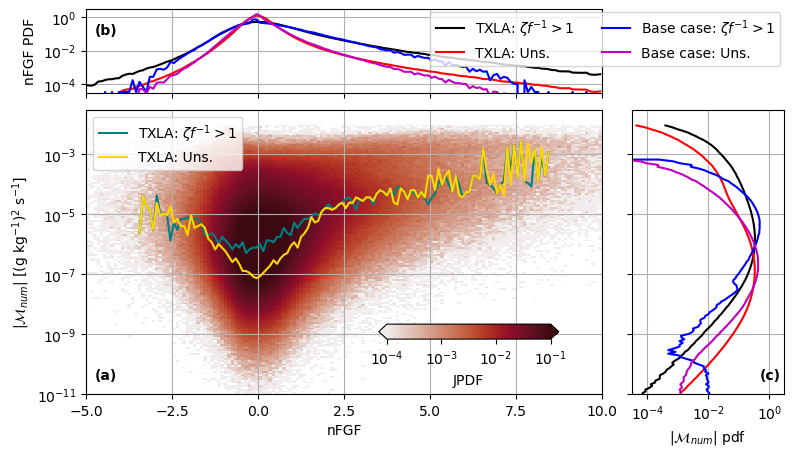

In [44]:
fig = plt.figure(figsize = (9,5))
gs = GridSpec(4, 4)

axm = fig.add_subplot(gs[1:4, 0:3])
ax_t = fig.add_subplot(gs[0,0:3])
ax_r = fig.add_subplot(gs[1:4, 3])

d = axm.pcolormesh(txla_jpdf_fronts['nFGF_bin'].values, txla_jpdf_fronts['dye_03_bin'].values, np.log10((txla_jpdf_fronts.T).values),
                   vmin = -4, vmax = -1,
                   cmap = cmo.amp)

cax = fig.add_axes([0.45, 0.22, 0.2, 0.03])
fig.colorbar(d, cax=cax, orientation='horizontal', label = 'JPDF', extend = 'both', format=tick.FormatStrFormatter('$10^{%d}$'))

p =axm.plot(fgf_centers[15:-15], mnum_centers[idx][15:-15], '-', color='teal', lw=1.5, label = r'TXLA: $\zeta f^{-1}>1$')
q = axm.plot(fgf_centers[15:-15], mnum_centers[idx1][15:-15], '-', color='gold', lw=1.5, label = r'TXLA: Uns.')
axm.legend(loc = 'upper left')

axm.grid()
axm.set_xticks([-5,-2.5,0,2.5,5,7.5,10])
axm.set_yticks([-11,-9,-7,-5,-3,-1])
axm.set_yticklabels([r'10$^{-11}$','10$^{-9}$','10$^{-7}$','10$^{-5}$','10$^{-3}$','10$^{-1}$'])
axm.set_xlabel('nFGF')
axm.set_ylim(-11,-1.5)
axm.set_ylabel('$|\mathcal{M}_{num}|$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
axm.set_xlim(-5,10)

ax_t.semilogy(txla_npdf_fronts['nFGF_bin'].values, txla_npdf_fronts, lw = 1.5, c='k', label = r'TXLA: $\zeta f^{-1}>1$')
ax_t.semilogy(txla_npdf['nFGF_bin'].values, txla_npdf, lw = 1.5, c='r', label = r'TXLA: Uns.')
ax_t.semilogy(shel_npdf_fronts['nFGF_bin'].values, shel_npdf_fronts, lw = 1.5, c='b', label = r'Base case: $\zeta f^{-1}>1$')
ax_t.semilogy(shel_npdf['nFGF_bin'].values, shel_npdf, lw = 1.5, c='m', label = r'Base case: Uns.')
ax_t.legend(ncol = 2, loc = 'upper right', bbox_to_anchor=(1.36, 1.05))

ax_t.grid()
ax_t.set_xlim(-5,10)
ax_t.set_xticks([-5,-2.5,0,2.5,5,7.5,10])
ax_t.set_yticks([10**-4,10**-2,10**-0])
ax_t.set_xticklabels('')
ax_t.set_ylim(10**-4.5,3)
ax_t.set_ylabel(r'nFGF PDF')

ax_r.semilogx(txla_mpdf_fronts,txla_mpdf_fronts['dye_03_bin'], lw = 1.5, c='k')
ax_r.semilogx(txla_mpdf,txla_mpdf['dye_03_bin'], lw = 1.5, c='r')
ax_r.semilogx(shel_mpdf_fronts,shel_mpdf_fronts['dye_03_bin'], lw = 1.5, c='b')
ax_r.semilogx(shel_mpdf,shel_mpdf['dye_03_bin'], lw = 1.5, c='m')
ax_r.set_yticks([-11,-9,-7,-5,-3,-1])
ax_r.set_xticks([10**-4,10**-2,10**0])
ax_r.set_xlim(10**-4.5,3)
ax_r.set_ylim(-11,-1.5)
ax_r.grid()
ax_r.set_yticklabels('')
ax_r.set_xlabel(r'$|\mathcal{M}_{num}|$ pdf')

axm.text(-4.75, -10.5, '(a)', fontweight = 'bold')
ax_t.text(-4.75, 0.1, '(b)', fontweight = 'bold')
ax_r.text(0.5, -10.5, '(c)', fontweight = 'bold')

plt.savefig('txla_shelfstrat_jpdf.png', dpi = 600, bbox_inches='tight')

/tmp/ipykernel_29553/2542091076.py:8: RuntimeWarning: divide by zero encountered in log10
  d = axm.pcolormesh(shel_jpdf_fronts['nFGF_bin'].values, shel_jpdf_fronts['dye_03_bin'].values, np.log10((shel_jpdf_fronts.T).values),


Text(0.5, 0, '$|\\mathcal{M}_{num}|$ pdf')

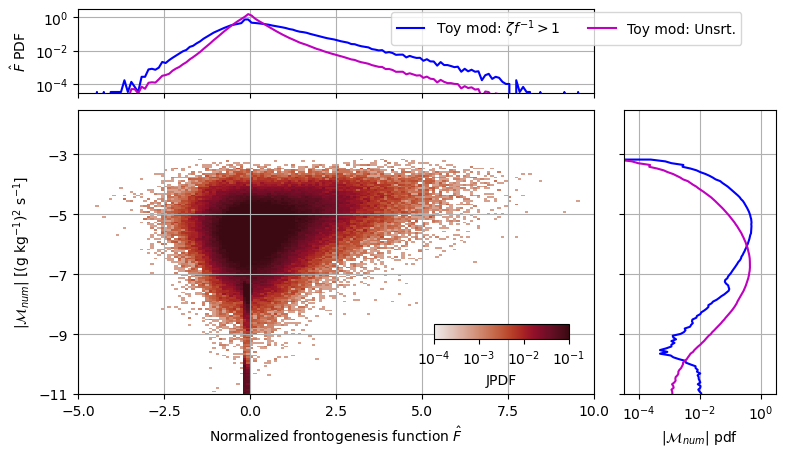

In [138]:
fig = plt.figure(figsize = (9,5))
gs = GridSpec(4, 4)

axm = fig.add_subplot(gs[1:4, 0:3])
ax_t = fig.add_subplot(gs[0,0:3])
ax_r = fig.add_subplot(gs[1:4, 3])

d = axm.pcolormesh(shel_jpdf_fronts['nFGF_bin'].values, shel_jpdf_fronts['dye_03_bin'].values, np.log10((shel_jpdf_fronts.T).values),
                   vmin = -4, vmax = -1,
                   cmap = cmo.amp)

cax = fig.add_axes([0.52, 0.22, 0.15, 0.03])
fig.colorbar(d, cax=cax, orientation='horizontal', label = 'JPDF',format=tick.FormatStrFormatter('$10^{%d}$'))

# p =axm.plot(fgf_centers[15:-15], mnum_centers[idx][15:-15], '-', color='teal', lw=1.5, label = r'TXLA: $\zeta f^{-1}>1$')
# q = axm.plot(fgf_centers[15:-15], mnum_centers[idx1][15:-15], '-', color='gold', lw=1.5, label = r'TXLA: Unsorted')
# axm.legend(loc = 'upper left')

axm.grid()
axm.set_xticks([-5,-2.5,0,2.5,5,7.5,10])
axm.set_yticks([-11,-9,-7,-5,-3,-1])
axm.set_xlabel('Normalized frontogenesis function $\hat{F}$')
axm.set_ylim(-11,-1.5)
axm.set_ylabel('$|\mathcal{M}_{num}|$ [(g kg$^{-1}$)$^2$ s$^{-1}$]')
axm.set_xlim(-5,10)

# ax_t.semilogy(txla_npdf_fronts['nFGF_bin'].values, txla_npdf_fronts, lw = 1.5, c='k', label = r'TXLA: $\zeta f^{-1}>1$')
# ax_t.semilogy(txla_npdf['fgf_bin'].values, txla_npdf, lw = 1.5, c='r', label = r'TXLA: Unsrt.')
ax_t.semilogy(shel_npdf_fronts['nFGF_bin'].values, shel_npdf_fronts, lw = 1.5, c='b', label = r'Toy mod: $\zeta f^{-1}>1$')
ax_t.semilogy(shel_npdf['fgf_bin'].values, shel_npdf, lw = 1.5, c='m', label = r'Toy mod: Unsrt.')
ax_t.legend(ncol = 2, loc = 'upper right', bbox_to_anchor=(1.3, 1.05))

ax_t.grid()
ax_t.set_xlim(-5,10)
ax_t.set_xticks([-5,-2.5,0,2.5,5,7.5,10])
ax_t.set_yticks([10**-4,10**-2,10**-0])
ax_t.set_xticklabels('')
ax_t.set_ylim(10**-4.5,3)
ax_t.set_ylabel(r'$\hat{F}$ PDF')

# ax_r.semilogx(txla_mpdf_fronts,txla_mpdf_fronts['dye_03_bin'], lw = 1.5, c='k')
# ax_r.semilogx(txla_mpdf,txla_mpdf['dye_03_bin'], lw = 1.5, c='r')
ax_r.semilogx(shel_mpdf_fronts,shel_mpdf_fronts['dye_03_bin'], lw = 1.5, c='b')
ax_r.semilogx(shel_mpdf,shel_mpdf['dye_03_bin'], lw = 1.5, c='m')
ax_r.set_yticks([-11,-9,-7,-5,-3,-1])
ax_r.set_xticks([10**-4,10**-2,10**0])
ax_r.set_xlim(10**-4.5,3)
ax_r.set_ylim(-11,-1.5)
ax_r.grid()
ax_r.set_yticklabels('')
ax_r.set_xlabel(r'$|\mathcal{M}_{num}|$ pdf')

### Definitely not looking as nice. But one question, what is going on with the high proportion of negative numerical mixing at very small values?
I think the wind is pushing water directly the coastal boundary. There's almost no numerical mixing here because there is zero lateral tracer gradients. That's why they're so small. 